# Data exploration

## Installing dependencies


In [ ]:
import torch
torch.__version__

'1.11.0+cu102'

In [ ]:
# Attempting to install the old version of Pytorch
# !pip install torchvision==0.12.0
# !pip install torchaudio==0.11.0
# !pip install torchtext==0.12.0
# !pip install torch==1.11.0
# !pip install pytorch-lightning==1.5.10 --quiet
# !pip install transformers==4.17.0 --quiet
# !pip install watermark
# !pip install Markdown==3.3.4

In [ ]:
# %reload_ext watermaacosrk
# %watermark -v -p numpy,pandas,sklearn,torch,pytorch_lightning,transformers

In [ ]:
# %watermark?

In [ ]:
from typing import Optional
import os

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchmetrics
from transformers import ElectraModel, ElectraPreTrainedModel, ElectraTokenizerFast as ElectraTokenizer, AdamW
from transformers.models.electra.modeling_electra import ElectraClassificationHead

import torch
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette (sns.color_palette (HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(42)

Global seed set to 42


42

## Downloading data from Google Drive

In [ ]:
# !wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
# !wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
# !wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Exploring the data

In [ ]:
# dataset_drive_path = "/content/drive/MyDrive/Master thesis/Emotion Classification/GoEmotions dataset"
#dataset_drive_path = "/kaggle/input/goemotions/data/full_dataset" # Kaggle specific
dataset_path = "GoEmotions_dataset/"

file_paths = list(Path(dataset_path).glob("*.csv"))

dfs = []
for file_path in file_paths:
  dfs.append(pd.read_csv(file_path))
df = pd.concat(dfs)
df.created_utc = pd.to_datetime(df.created_utc, unit='s') # This is not mandatory
df.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Worst ending ever! I won't spoil it but this o...,eee021b,tribaltrak,movies,t3_agxbsx,t3_agxbsx,2019-01-18 21:36:54,42,False,0,...,0,0,0,0,0,0,0,0,0,0
1,Happy cake day u/sneakpeekbot!,ed00f1z,InfernicFuse,danganronpa,t3_abajdo,t1_eczoocj,2019-01-01 07:26:46,24,False,0,...,0,0,0,0,0,0,0,0,0,0
2,Was he rejected because of his methodology or ...,ee1h5v1,OssToYouGoodSir,medicine,t3_aflo7s,t1_ee0v0vv,2019-01-14 11:04:27,77,False,0,...,0,0,0,0,0,0,0,0,0,0
3,"thanks, I agree",eemi935,PMOFreeForever,NoFap,t3_ai7h09,t1_eelu54r,2019-01-21 16:27:59,46,False,0,...,0,0,0,0,0,0,0,0,0,0
4,Why would you doubt it dumbass?,eduun99,ugliestman1,Tinder,t3_aejwne,t1_edumeal,2019-01-12 01:10:44,36,False,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(211225, 37)

In [ ]:
df.groupby("id").head(1).shape

(58011, 37)

In [ ]:
emotion_categories = df.columns[9:]
emotion_categories

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [ ]:
row = df.iloc[10]
sample_ratings = df[df.id == row.id]
sample_ratings

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
10,How about a downvote for the update?,ef9q28z,H010CR0N,entitledparents,t3_al0vqd,t1_ef9nein,2019-01-29 15:57:22,3,False,0,...,0,0,0,0,0,0,0,0,0,0
55681,How about a downvote for the update?,ef9q28z,H010CR0N,entitledparents,t3_al0vqd,t1_ef9nein,2019-01-29 15:57:22,40,False,0,...,0,0,0,0,0,0,0,0,0,1
15954,How about a downvote for the update?,ef9q28z,H010CR0N,entitledparents,t3_al0vqd,t1_ef9nein,2019-01-29 15:57:22,60,False,0,...,0,0,0,0,0,0,0,0,0,1
36433,How about a downvote for the update?,ef9q28z,H010CR0N,entitledparents,t3_al0vqd,t1_ef9nein,2019-01-29 15:57:22,79,False,0,...,0,0,0,0,0,0,0,0,0,0
24246,How about a downvote for the update?,ef9q28z,H010CR0N,entitledparents,t3_al0vqd,t1_ef9nein,2019-01-29 15:57:22,20,False,0,...,0,0,0,0,0,0,0,0,0,0


There are multiple ratings for the same text, corresponding to the different people that are doing the ratings.

## Tokenizing a sample reddit comment

In [ ]:
sample_ratings.iloc[0].text

'How about a downvote for the update?'

In [ ]:
ratings = sample_ratings[emotion_categories]
ratings = ratings.columns[ratings.sum(axis=0) > 0]
ratings = ", ".join(ratings)
ratings

'approval, confusion, curiosity, neutral'

In [ ]:
print(f"text:       {row.text}")
print(f"emotions:   {ratings}")

text:       How about a downvote for the update?
emotions:   approval, confusion, curiosity, neutral


In [ ]:
from transformers import ElectraTokenizerFast as ElectraTokenizer

# MODEL_NAME = "google/electra-base-discriminator"
MODEL_NAME = "google/electra-base-discriminator"

tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
encoding = tokenizer(row.text)
print(f"Text:      {row.text}")
print(f"Tokens:    {encoding.tokens()}")
print(f"Token IDs: {encoding.input_ids}")

Text:      How about a downvote for the update?
Tokens:    ['[CLS]', 'how', 'about', 'a', 'down', '##vot', '##e', 'for', 'the', 'update', '?', '[SEP]']
Token IDs: [101, 2129, 2055, 1037, 2091, 22994, 2063, 2005, 1996, 10651, 1029, 102]


In [ ]:
encoding

{'input_ids': [101, 2129, 2055, 1037, 2091, 22994, 2063, 2005, 1996, 10651, 1029, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Choosing a good sequence length

In [ ]:
from tqdm import tqdm

token_lens = []

texts = df.groupby("id").head(1).text

for text in tqdm(texts):
  encoding = tokenizer(text)
  token_lens.append(len(encoding.tokens()))

100%|██████████████████████████████████████████| 58011/58011 [00:09<00:00, 6223.32it/s]


In [ ]:
pd.Series(token_lens).value_counts().sort_index(ascending=False)[:10]

316    1
115    1
82     1
63     1
57     1
55     1
54     1
53     1
52     2
51     1
dtype: int64

Text(0.5, 0, 'Token count')

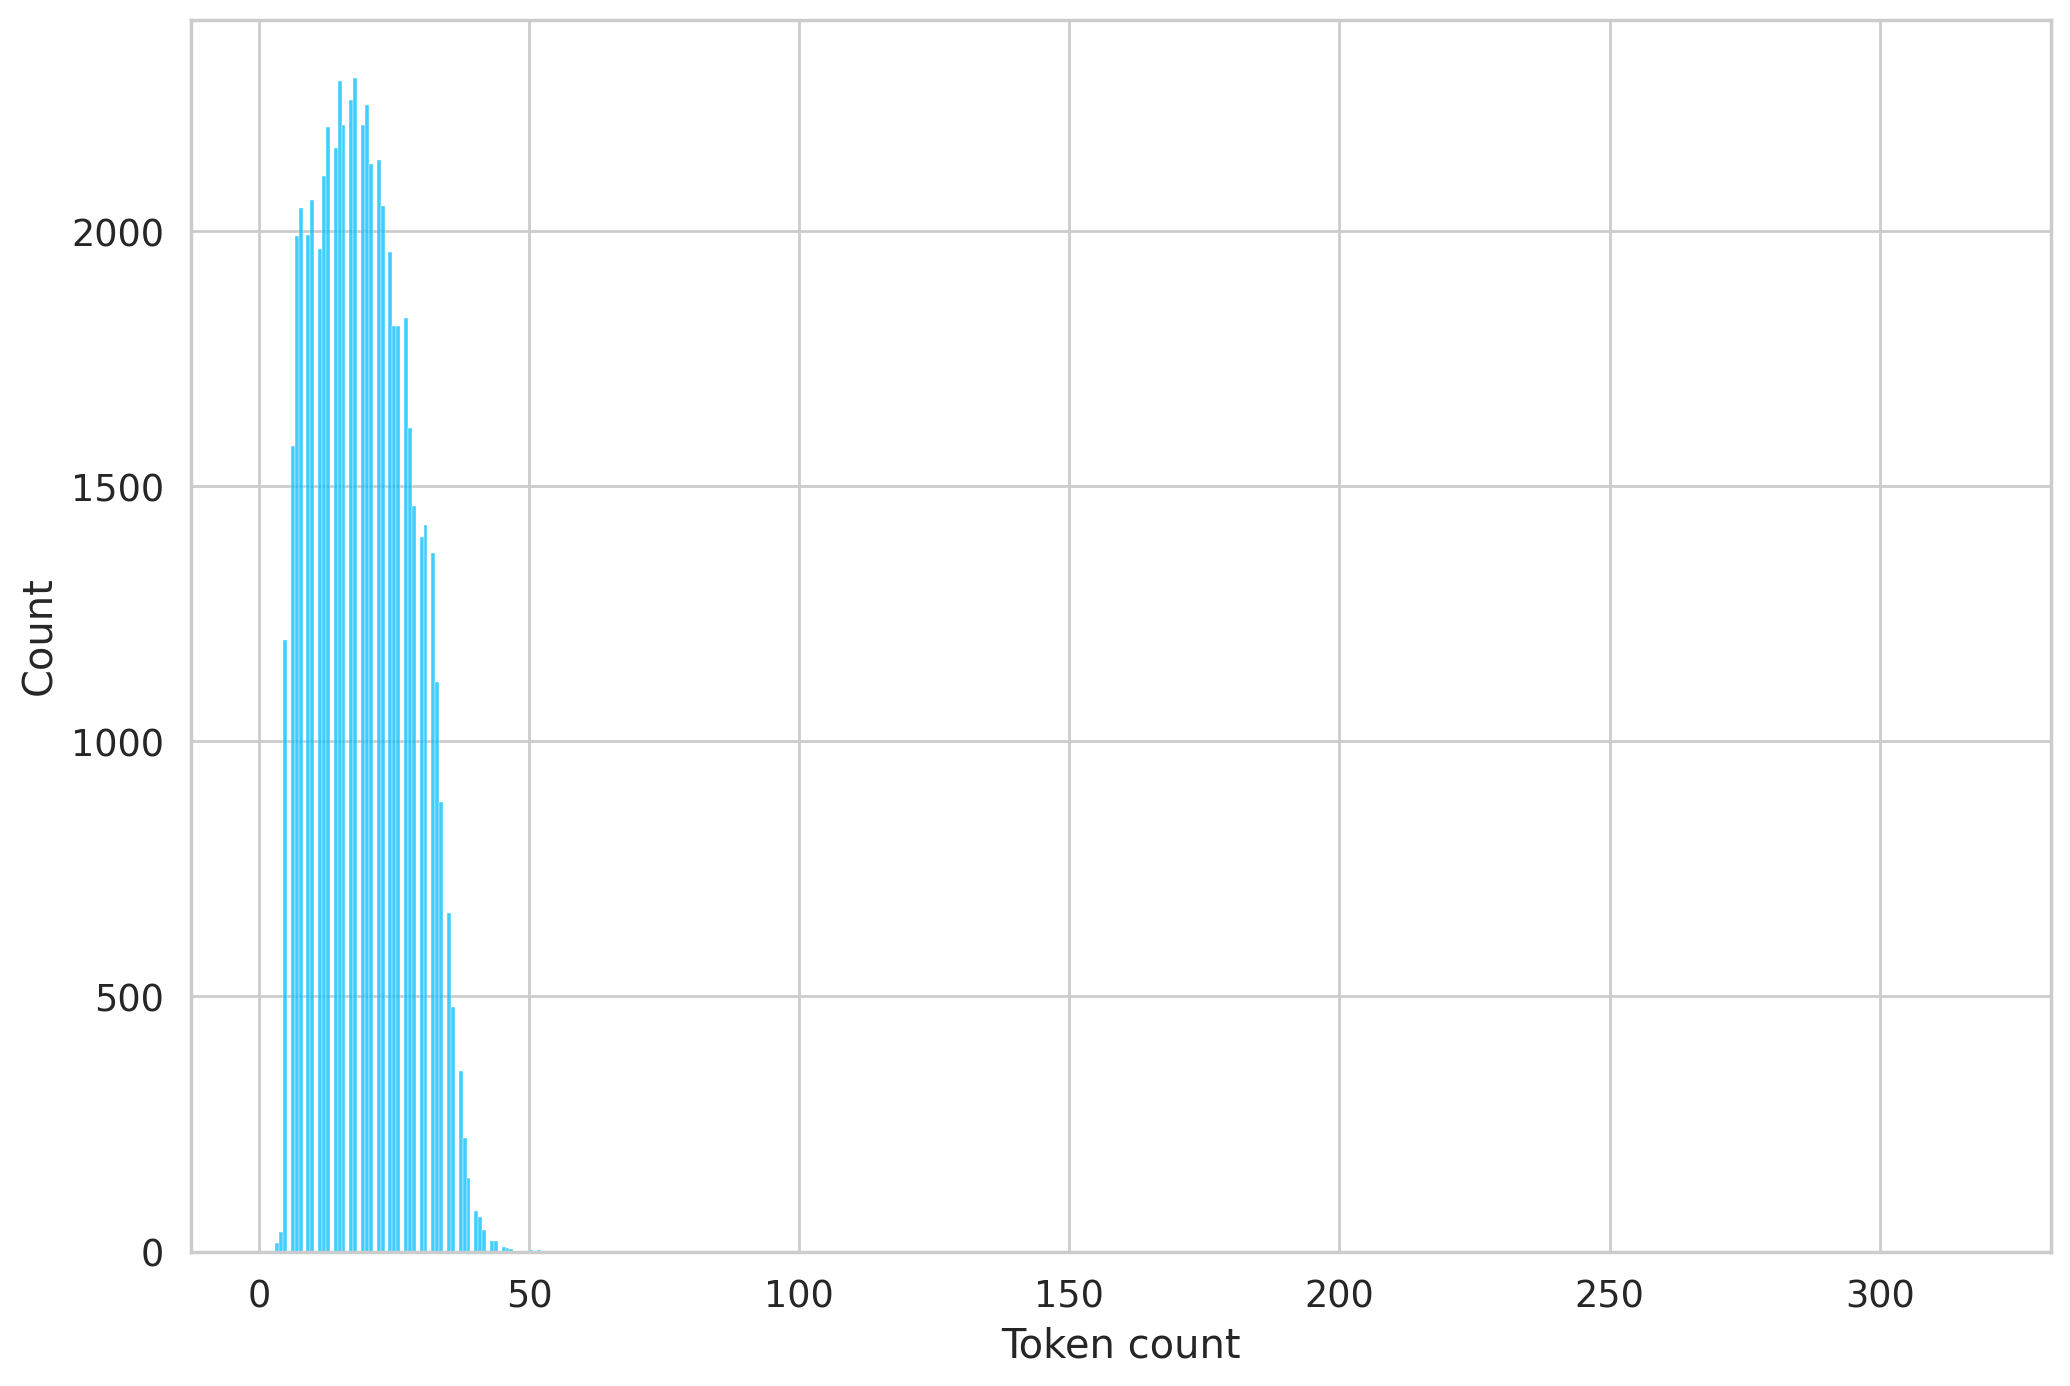

In [ ]:
sns.histplot(token_lens)
plt.xlabel("Token count")

We can see that almost all tokens lengths are less than 64 tokens. Therefore, we can use 64 sequences for the tokenizer to accelerate training.

Text(0.5, 0, 'Token count')

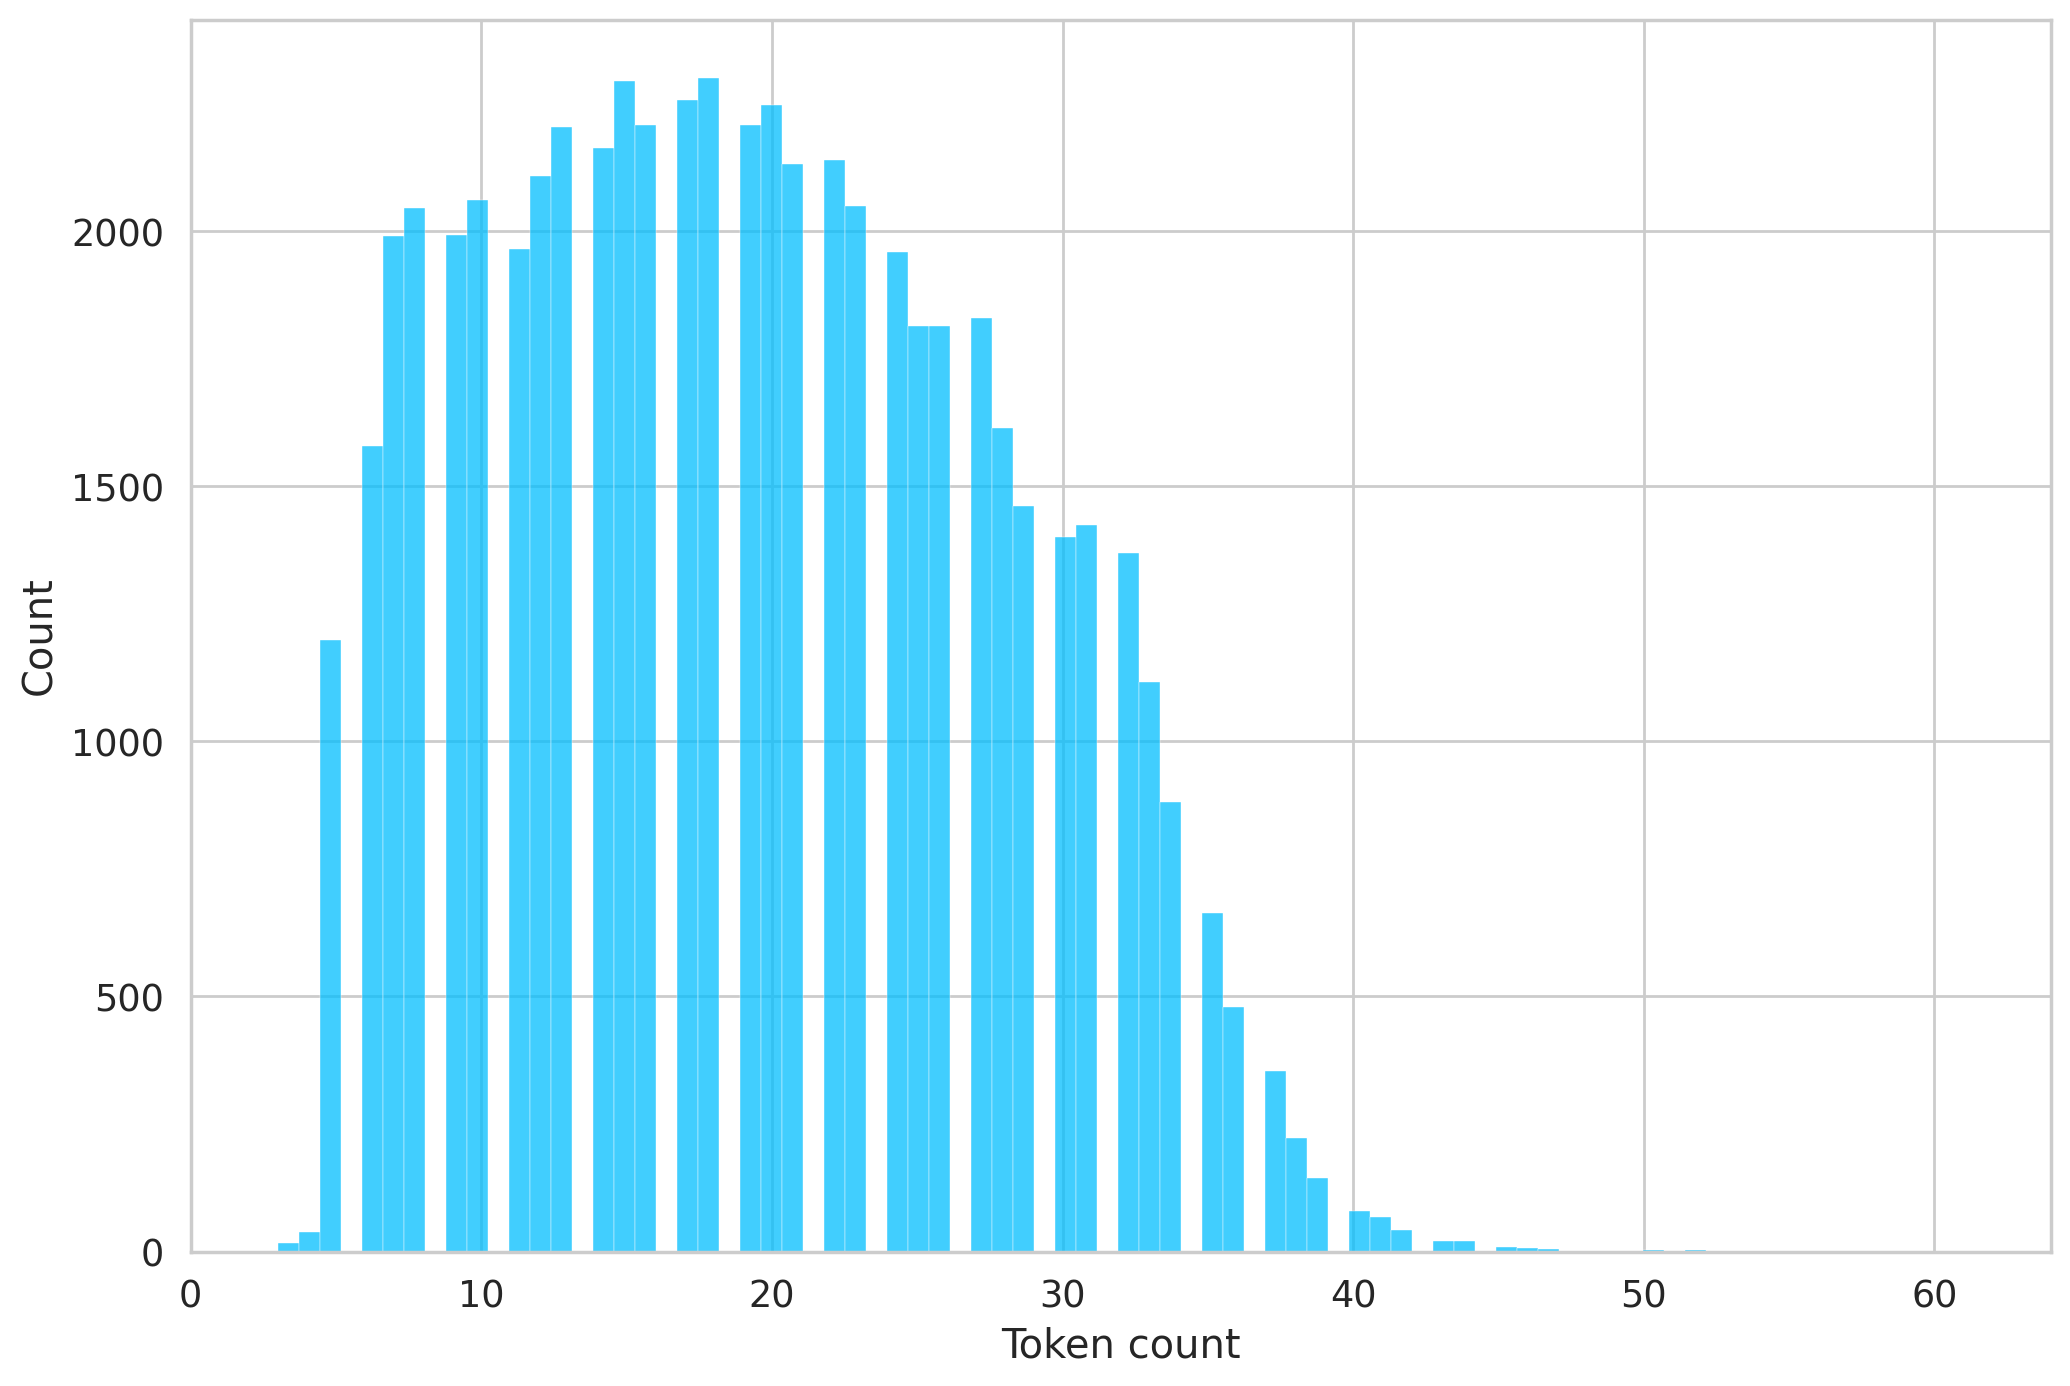

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 64])
plt.xlabel("Token count")

# Building a custom dataset

In [ ]:
df.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Worst ending ever! I won't spoil it but this o...,eee021b,tribaltrak,movies,t3_agxbsx,t3_agxbsx,2019-01-18 21:36:54,42,False,0,...,0,0,0,0,0,0,0,0,0,0
1,Happy cake day u/sneakpeekbot!,ed00f1z,InfernicFuse,danganronpa,t3_abajdo,t1_eczoocj,2019-01-01 07:26:46,24,False,0,...,0,0,0,0,0,0,0,0,0,0
2,Was he rejected because of his methodology or ...,ee1h5v1,OssToYouGoodSir,medicine,t3_aflo7s,t1_ee0v0vv,2019-01-14 11:04:27,77,False,0,...,0,0,0,0,0,0,0,0,0,0
3,"thanks, I agree",eemi935,PMOFreeForever,NoFap,t3_ai7h09,t1_eelu54r,2019-01-21 16:27:59,46,False,0,...,0,0,0,0,0,0,0,0,0,0
4,Why would you doubt it dumbass?,eduun99,ugliestman1,Tinder,t3_aejwne,t1_edumeal,2019-01-12 01:10:44,36,False,0,...,0,0,0,0,0,0,0,0,0,0


Since multiple annotators do not necessarily agree on the emotion label, we're going to take the most frequent emotion as the real label:

In [ ]:
texts = []
emotions = []

for comment_id, group in tqdm(df.groupby("id")):
  texts.append(group.iloc[0].text)
  emotions.append(group[emotion_categories].sum(axis=0).argmax())

100%|███████████████████████████████████████████| 58011/58011 [01:22<00:00, 700.21it/s]


In [ ]:
text_df = pd.DataFrame({"text": texts, "emotion": emotions})
text_df.head()

,text,emotion
0,Fast as [NAME] will carry me. Seriously uptown...,4
1,You blew it. They played you like a fiddle.,27
2,TL;DR No more Superbowls for [NAME]. Get ready...,9
3,So much time saved. Not.,7
4,Emotes have a ridiculous amount of effort put ...,27


In [ ]:
from numpy import index_exp
class EmotionDataset(Dataset):
  def __init__(self, data: pd.DataFrame, tokenizer: ElectraTokenizer):
    self.data = data
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    encoding = tokenizer(
        row.text,
        max_length=64,
        truncation=True,
        padding="max_length",
        add_special_tokens=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors="pt"
    )

    return {
        "input_ids": encoding["input_ids"].flatten(),
        "attention_mask": encoding["attention_mask"].flatten(),
        "label": torch.tensor(row.emotion)
    }

In [ ]:
ds = EmotionDataset(text_df, tokenizer)
print(len(ds) == len(text_df))

True


In [ ]:
for item in ds:
  print(item["input_ids"][:10])
  print(item["label"])
  break

tensor([ 101, 3435, 2004, 1031, 2171, 1033, 2097, 4287, 2033, 1012])
tensor(4)


In [ ]:
from matplotlib import test
class EmotionDataModule(pl.LightningDataModule):
  def __init__(
      self, data: pd.DataFrame, tokenizer: ElectraTokenizer, batch_size: int
  ):
    self.data = data
    self.tokenizer = tokenizer
    self.batch_size = batch_size

  def setup(self, stage: Optional[str] = None):
    self.train_df, test_df = train_test_split(self.data, test_size=0.2)
    self.val_df, self.test_df = train_test_split(test_df, test_size=0.5)

  def train_dataloader(self):
    return DataLoader(
        dataset=EmotionDataset(self.train_df, self.tokenizer),
        batch_size=self.batch_size,
        num_workers=os.cpu_count(),
        shuffle=True
    )

  def val_dataloader(self):
    return DataLoader(
        dataset=EmotionDataset(self.val_df, self.tokenizer),
        batch_size=self.batch_size,
        num_workers=os.cpu_count(),
        shuffle=False
    )

  def test_dataloader(self):
    return DataLoader(
        dataset=EmotionDataset(self.test_df, self.tokenizer),
        batch_size=self.batch_size,
        num_workers=os.cpu_count(),
        shuffle=False
    )

In [ ]:
data_module = EmotionDataModule(text_df, tokenizer, batch_size=32)
data_module.setup()

In [ ]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [ ]:
for batch in data_module.train_dataloader():
  print(len(batch))
  print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["label"].shape)
  break

3
torch.Size([32, 64]) torch.Size([32, 64]) torch.Size([32])


# Google ELECTRA classifier

## About the ELECTRA model

### **Summary**

The pre-training task for popular language models like BERT and XLNet involves masking a small subset of unlabeled input and then training the network to recover this original input. Even though it works quite well, this approach is not particularly data-efficient as it learns from only a small fraction of tokens (typically ~15%). As an alternative, the researchers from Stanford University and Google Brain propose a new pre-training task called replaced token detection. Instead of masking, they suggest replacing some tokens with plausible alternatives generated by a small language model. Then, the pre-trained discriminator is used to predict whether each token is an original or a replacement. As a result, the model learns from all input tokens instead of the small masked fraction, making it much more computationally efficient. The experiments confirm that the introduced approach leads to significantly faster training and higher accuracy on downstream NLP tasks.

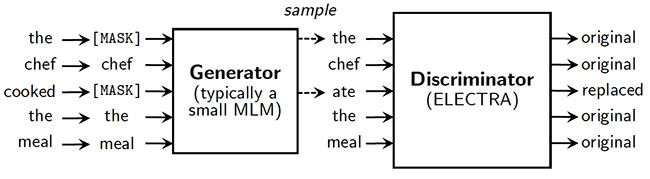

### **What’s the core idea of this paper?**



*   Pre-training methods that are based on masked language modeling are computationally inefficient as they use only a small fraction of tokens for learning.
*   Researchers propose a new pre-training task called replaced token detection, where some tokens are replaced by samples from a small generator network, and a model is pre-trained as a discriminator to distinguish between original and replaced tokens.
*   The introduced approach, called ELECTRA (Efficiently Learning an Encoder that Classifies Token Replacements Accurately): enables the model to learn from all input tokens instead of the small masked-out subset; and is not adversarial, despite the similarity to GAN, as the generator producing tokens for replacement is trained with maximum likelihood.





### **What’s the key achievement?**



*   Demonstrating that the discriminative task of distinguishing between real data and challenging negative samples is more efficient than existing generative methods for language representation learning.

*   Introducing a model that substantially outperforms state-of-the-art approaches while requiring less pre-training compute:
ELECTRA-Small gets a GLUE score of 79.9 and outperforms a comparably small BERT model with a score of 75.1 and a much larger GPT model with a score of 78.8.
An ELECTRA model that performs comparably to XLNet and RoBERTa uses only 25% of their pre-training compute.
ELECTRA-Large outscores the alternative state-of-the-art models on the GLUE and SQuAD benchmarks while still requiring less pre-training compute.


## Pipeline

### Mask prediction

In [ ]:
from transformers import pipeline
import json

fill_mask = pipeline(
    "fill-mask",
    #model="google/electra-base-generator",
    model="google/electra-small-generator",
    #tokenizer="google/electra-base-generator",
    tokenizer="google/electra-small-generator",
    top_k=3
)

In [ ]:
sample_text = "The sky is cloudy, it's probably going to [MASK]."

print(json.dumps(fill_mask(sample_text), indent=4))

[
    {
        "score": 0.1420627236366272,
        "token": 2022,
        "token_str": "be",
        "sequence": "the sky is cloudy, it's probably going to be."
    },
    {
        "score": 0.09350328892469406,
        "token": 4542,
        "token_str": "rain",
        "sequence": "the sky is cloudy, it's probably going to rain."
    },
    {
        "score": 0.05372244119644165,
        "token": 4586,
        "token_str": "snow",
        "sequence": "the sky is cloudy, it's probably going to snow."
    }
]


## Discriminator

The discriminator's task is to get the tokens and decide if each token was replaced or not.

In [ ]:
from transformers import ElectraForPreTraining

# model = ElectraForPreTraining.from_pretrained("google/electra-small-discriminator")
model = ElectraForPreTraining.from_pretrained("google/electra-base-discriminator")

In [ ]:
sample_text = "I am happy because I am doing research."

encoding = tokenizer(sample_text, return_tensors="pt")
outputs = model(**encoding)

In [ ]:
encoding

{'input_ids': tensor([[ 101, 1045, 2572, 3407, 2138, 1045, 2572, 2725, 2470, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
encoding.tokens()

['[CLS]',
 'i',
 'am',
 'happy',
 'because',
 'i',
 'am',
 'doing',
 'research',
 '.',
 '[SEP]']

In [ ]:
outputs

ElectraForPreTrainingOutput(loss=None, logits=tensor([[-9.9171, -5.8865, -3.5302, -2.0731, -1.9720, -5.9219, -3.2721, -3.3904,
         -1.5352, -5.2458, -9.9171]], grad_fn=<SqueezeBackward1>), hidden_states=None, attentions=None)

In [ ]:
outputs.logits

tensor([[-9.9171, -5.8865, -3.5302, -2.0731, -1.9720, -5.9219, -3.2721, -3.3904,
         -1.5352, -5.2458, -9.9171]], grad_fn=<SqueezeBackward1>)

In [ ]:
torch.softmax(outputs.logits, dim=-1)

tensor([[8.3299e-05, 4.6893e-03, 4.9480e-02, 2.1244e-01, 2.3505e-01, 4.5263e-03,
         6.4055e-02, 5.6905e-02, 3.6379e-01, 8.8990e-03, 8.3299e-05]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
torch.softmax(outputs.logits, dim=-1).sum()

tensor(1.0000, grad_fn=<SumBackward0>)

The sum is 1 so this is basically a probability distribution.

In [ ]:
def show_detections(tokens, logits):
  replaced_token_index = torch.argmax(logits, dim=-1).item()

  special_tokens = set(tokenizer.special_tokens_map.values())

  for i, token in enumerate(tokens):
    if token in special_tokens:
      continue
    elif i == replaced_token_index:
      print(f"{token} -> replaced")
    else:
      print(f"{token} -> original")

In [ ]:
show_detections(encoding.tokens(), outputs.logits)

i -> original
am -> original
happy -> original
because -> original
i -> original
am -> original
doing -> original
research -> replaced
. -> original


## Emotion Classifier

In [ ]:
class ElectraClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(x)
        x = self.dense(x)
        x = get_activation("gelu")(x)  # although BERT uses tanh here, it seems Electra authors used gelu here
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

In [ ]:
#from transformers.utils.dummy_pt_objects import ElectraPreTrainedModel
class ElectraClassifier(ElectraPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)
    self.n_classes = config.num_labels
    self.config = config
    self.electra = ElectraModel(config)
    self.classifier = ElectraClassificationHead(config)

    self.post_init()

  def forward(
      self,
      input_ids=None,
      attention_mask=None
  ):
    discriminator_hidden_states = self.electra(input_ids, attention_mask)
    sequence_output = discriminator_hidden_states[0]
    logits = self.classifier(sequence_output)
    return logits

In [ ]:
class EmotionClassifier(pl.LightningModule):
  def __init__(self, n_classes, learning_rate: Optional[float]=None):
    super().__init__()
    self.n_classes = n_classes
    self.classifier = ElectraClassifier.from_pretrained(
        "google/electra-base-discriminator",
        #"google/electra-base-discriminator",
        num_labels=n_classes
    )
    self.criterion = nn.CrossEntropyLoss()
    self.learning_rate = learning_rate

  def forward(self, input_ids, attention_mask):
    return self.classifier(input_ids, attention_mask)

  def run_step(self, batch, stage):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["label"].long()
    logits = self(input_ids, attention_mask)

    loss = self.criterion(logits, labels)
    self.log(f"{stage}_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

    return loss

  def training_step(self, batch, batch_idx):
    return self.run_step(batch, "train")

  def validation_step(self, batch, batch_idx):
    return self.run_step(batch, "val")

  def test_step(self, batch, batch_idx):
    return self.run_step(batch, "test")

  def configure_optimizers(self):
    return AdamW(self.parameters(), lr=self.learning_rate)

In [ ]:
MAX_LEARNING_RATE = 1e-2
# BATCH_SIZE = 512
BATCH_SIZE = 128
TRAINING_STEPS = 650

data_module = EmotionDataModule(
    text_df,
    tokenizer,
    batch_size=BATCH_SIZE
)

model = EmotionClassifier(
    n_classes = len(emotion_categories),
    learning_rate = MAX_LEARNING_RATE
)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraClassifier: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraClassifier were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.

In [ ]:
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


In [ ]:
trainer = pl.Trainer(gpus=1)
# trainer = pl.Trainer(devices=3, accelerator="gpu")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
lr_finder = trainer.tuner.lr_find(model, data_module, max_lr=MAX_LEARNING_RATE)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]
/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/ahmed_b/Master_Thesis/electra_cls/lr_find_temp_model_d0a4dba4-9112-4990-9757-e6e30d02e9a5.ckpt


In [ ]:
lr_finder.results

{'lr': [1e-08,
  1.3182567385564071e-08,
  1.5135612484362082e-08,
  1.7378008287493757e-08,
  1.9952623149688796e-08,
  2.2908676527677733e-08,
  2.630267991895382e-08,
  3.019951720402016e-08,
  3.4673685045253164e-08,
  3.981071705534973e-08,
  4.570881896148751e-08,
  5.248074602497726e-08,
  6.025595860743578e-08,
  6.918309709189366e-08,
  7.943282347242814e-08,
  9.120108393559099e-08,
  1.0471285480508999e-07,
  1.2022644346174127e-07,
  1.380384264602885e-07,
  1.5848931924611136e-07,
  1.8197008586099835e-07,
  2.0892961308540398e-07,
  2.398832919019491e-07,
  2.7542287033381663e-07,
  3.162277660168379e-07,
  3.630780547701014e-07,
  4.1686938347033557e-07,
  4.786300923226385e-07,
  5.495408738576244e-07,
  6.309573444801932e-07,
  7.244359600749902e-07,
  8.317637711026711e-07,
  9.549925860214362e-07,
  1.0964781961431853e-06,
  1.2589254117941667e-06,
  1.4454397707459273e-06,
  1.6595869074375605e-06,
  1.9054607179632473e-06,
  2.187761623949553e-06,
  2.5118864315095

In [ ]:
!nvidia-smi

Wed Feb 15 11:54:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:04:00.0 Off |                  N/A |
| 29%   27C    P8    20W / 250W |      3MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:05:00.0 Off |                  N/A |
| 29%   

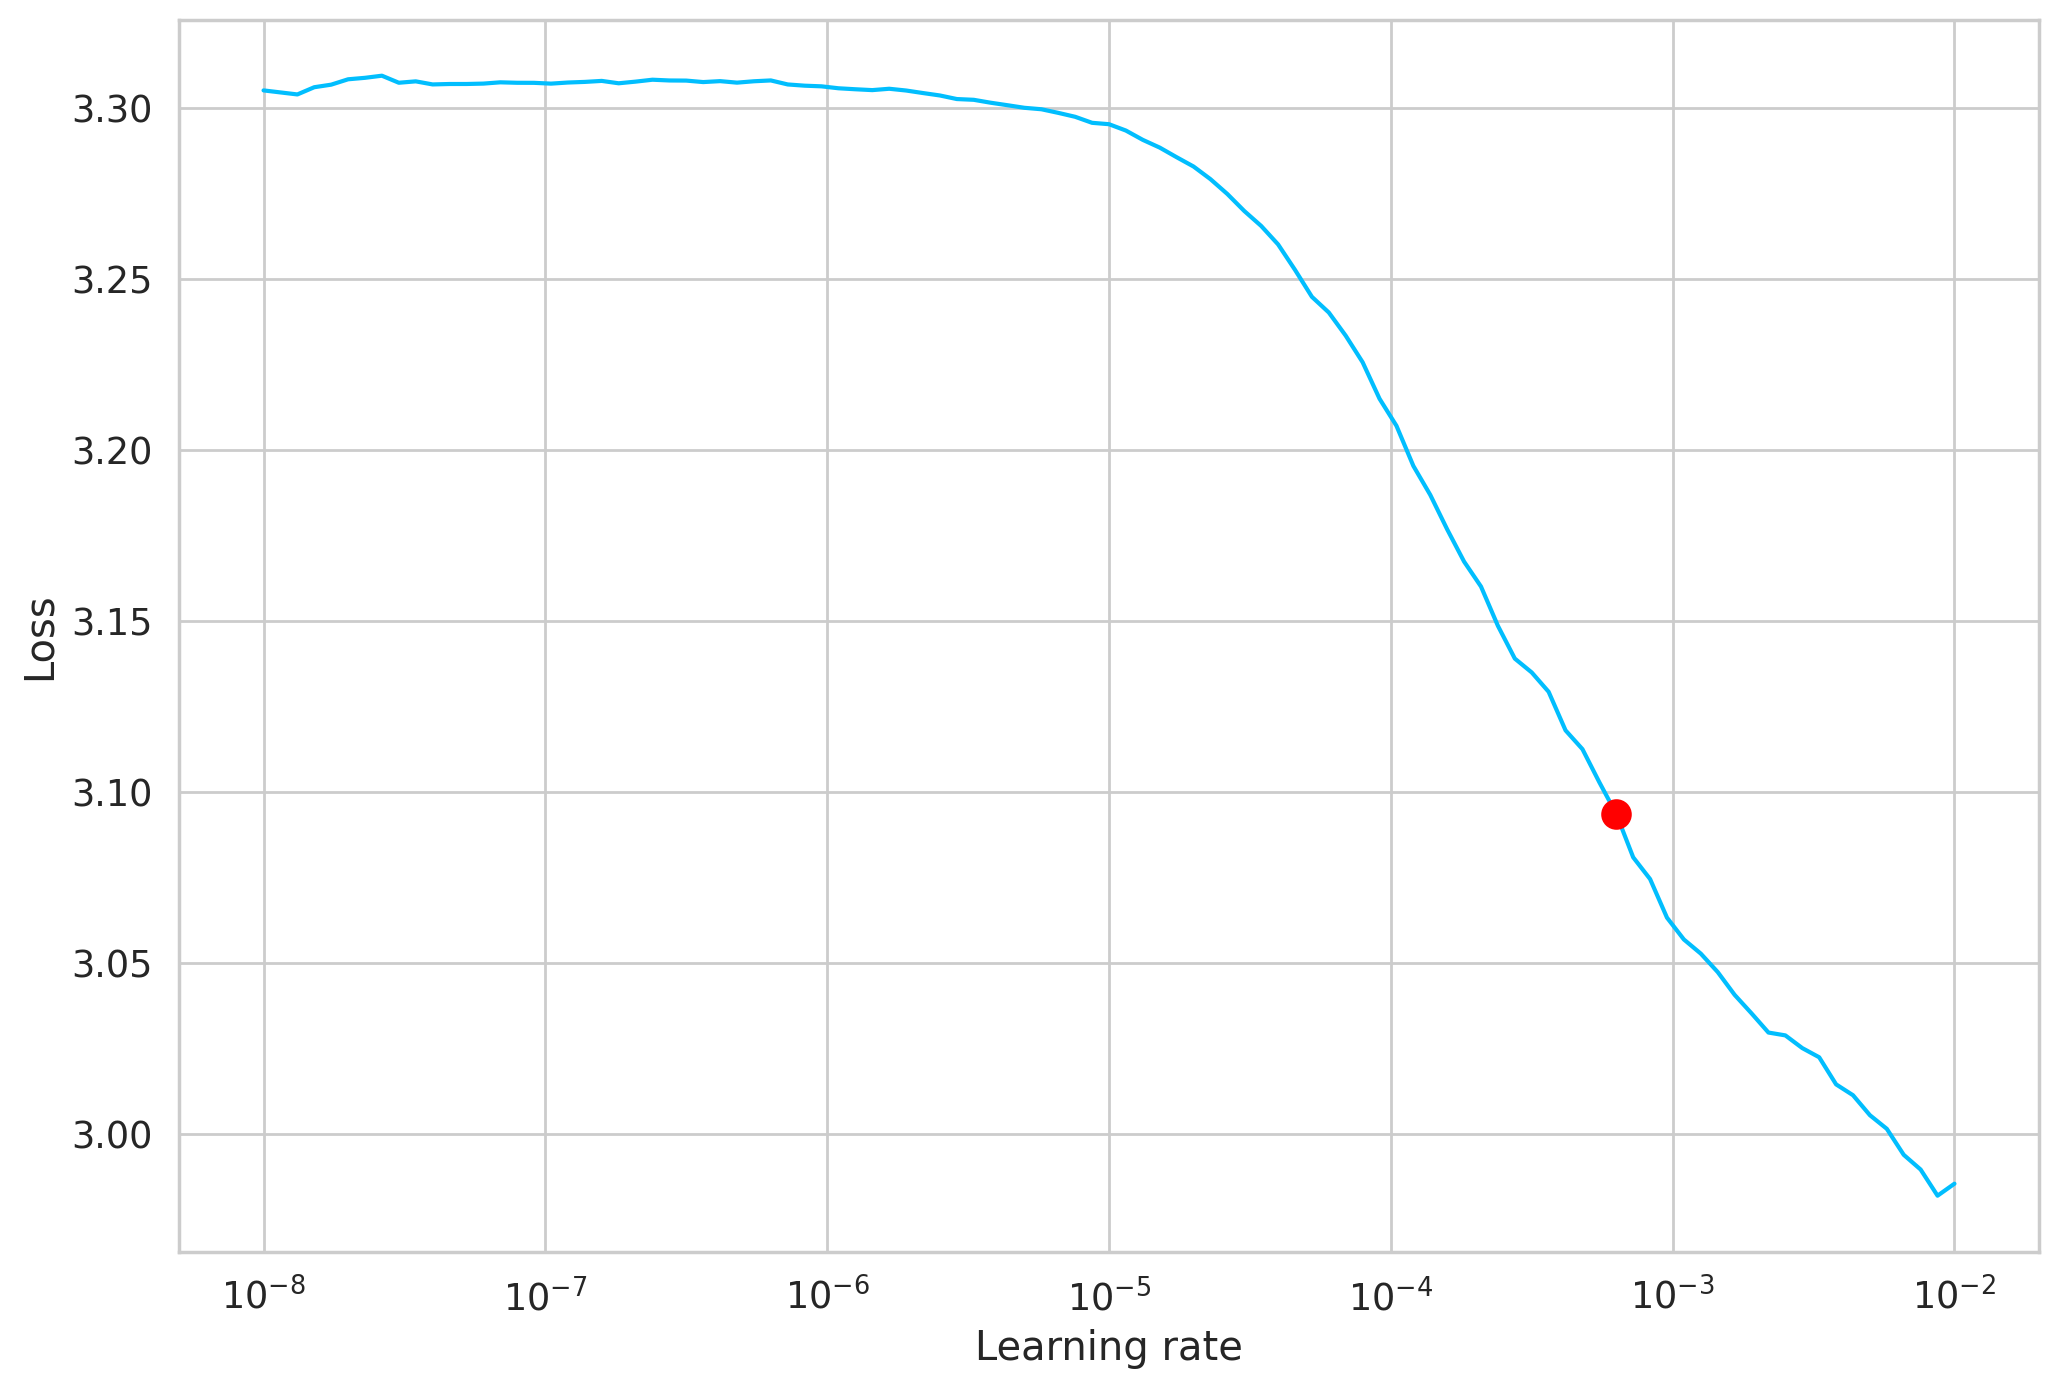

In [ ]:
fig = lr_finder.plot(suggest=True)

In [ ]:
new_lr = lr_finder.suggestion()
new_lr

0.0006309573444801936

In [ ]:
# model.learning_rate = new_lr
model.learning_rate = 0.0001

In [ ]:
%load_ext tensorboard

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
experiments_dir = "Master_Thesis/electra_cls/experiments"
#experiments_dir = "/content/drive/MyDrive/Master thesis/Emotion Classification/ELECTRA checkpoints"

model_checkpoint = ModelCheckpoint(
    filename="{epoch}-{step}-{val_loss:.2f}",
    save_last=True,
    save_top_k=3,
    monitor="val_loss_epoch",
    mode="min"
)

logger = TensorBoardLogger(save_dir=experiments_dir, name="emotion_classification")

In [ ]:
%tensorboard --logdir experiments_dir

In [ ]:
trainer = pl.Trainer(
    default_root_dir=experiments_dir,
    gpus=1,
    # devices=2, accelerator="gpu",
    max_epochs=20,
    # max_steps=TRAINING_STEPS,
    precision=16,
    val_check_interval=40,
    callbacks=[
        model_checkpoint
    ],
    logger=logger
)

In [ ]:
print("I am here!")

I am here!


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]
/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name       | Type              | Params
-------------------------------------------------
0 | classifier | ElectraClassifier | 109 M 
1 | criterion  | CrossEntropyLoss  | 0     
-------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.015   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trainer.test(datamodule=data_module)

/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1399: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /home/ahmed_b/Master_Thesis/electra_cls/lightning_logs/version_12/checkpoints/epoch=9-step=3629.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]
Loaded model weights from checkpoint at /home/ahmed_b/Master_Thesis/electra_cls/lightning_logs/version_12/checkpoints/epoch=9-step=3629.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.6115949153900146, 'test_loss_epoch': 0.6115949153900146}
--------------------------------------------------------------------------------


Traceback (most recent call last):
  File "/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ahmed_b/.conda/envs/electra_cls/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ahmed_b/

[{'test_loss': 0.6115949153900146, 'test_loss_epoch': 0.6115949153900146}]

In [ ]:
model.classifier.save_pretrained("emotion_classifier")

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path

In [ ]:
trainer.checkpoint_callback.best_model_path

'/home/ahmed_b/Master_Thesis/electra_cls/lightning_logs/version_12/checkpoints/epoch=9-step=3629.ckpt'

In [ ]:
# best_model_path = "/content/" + best_model_path
# best_model_path

In [ ]:
# cp -R $best_model_path "/content/drive/MyDrive/Master thesis/Emotion Classification"

In [ ]:
# best_model_checkpoint_folder = "/content/drive/MyDrive/Master thesis/Emotion Classification/"

In [ ]:
# best_model_checkpoint_path = str(list(Path(best_model_checkpoint_folder).glob("*.ckpt"))[0])

In [ ]:
trained_model = EmotionClassifier.load_from_checkpoint(
    # trainer.checkpoint_callback.best_model_path,
    best_model_path,
    n_classes=len(emotion_categories)
)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraClassifier: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraClassifier were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.

In [ ]:
trainer.checkpoint_callback.best_model_score

In [ ]:
trained_model.eval()

EmotionClassifier(
  (classifier): ElectraClassifier(
    (electra): ElectraModel(
      (embeddings): ElectraEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): ElectraEncoder(
        (layer): ModuleList(
          (0): ElectraLayer(
            (attention): ElectraAttention(
              (self): ElectraSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): ElectraSelfOutput(
                (dense): Linear(in_features=768, out_f

In [ ]:
# trained_model.freeze()

In [ ]:
def Predict_emotion(text, top_k=3):
  encoding = tokenizer(
          text,
          max_length=64,
          truncation=True,
          padding="max_length",
          add_special_tokens=True,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors="pt"
      )
  # outputs = trained_model(encoding["input_ids"], encoding["attention_mask"])
  outputs = trained_model(**encoding)
  probabilities = list(torch.softmax(outputs, dim=-1).detach().numpy().flatten())
  emotion_idx = torch.argmax(outputs, dim=-1).item()
  predicted_emotion = emotion_categories[emotion_idx]

  emotion_categories_list = list(emotion_categories)
  probabilities, emotion_categories_list = zip(*sorted(zip(probabilities, emotion_categories_list)))
  probabilities = probabilities[::-1]
  emotion_categories_list = emotion_categories_list[::-1]

  print(f'The sentence "{sample_text}"')
  print(f"Expresses the {predicted_emotion.upper()} emotion ({100*probabilities[0]:.0f}%).")

  print("\n-- Other probabilities: --\n")
  k = 1
  for label, probability in zip(list(emotion_categories_list), list(probabilities)):
    print(f"P({label}) = {100*probability:.2f}%.")
    k += 1
    if k > top_k:
      break

In [ ]:
sample_text = "I don't know what to do!"
Predict_emotion(sample_text)

The sentence "I don't know what to do!"
Expresses the CONFUSION emotion (99%).

-- Other probabilities: --

P(confusion) = 98.60%.
P(caring) = 0.33%.
P(fear) = 0.23%.


In [ ]:
emotion_categories

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

# Evaluating the model

In [ ]:
!nvidia-smi

Wed Feb 15 12:35:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:04:00.0 Off |                  N/A |
| 29%   27C    P8    20W / 250W |      3MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:05:00.0 Off |                  N/A |
| 29%   

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

MAX_TOKEN_COUNT = 64


trained_model = trained_model.to(device)

val_dataset = EmotionDataset(
  data_module.test_df,
  tokenizer
  )

predictions = []
labels = []
for item in tqdm(val_dataset):
  prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
    )
  prediction = prediction.flatten().detach().cpu()
  predictions.append(prediction)
  labels.append(item["label"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()


100%|██████████████████████████████████████████████| 5802/5802 [01:30<00:00, 64.34it/s]


In [ ]:
from torchmetrics.classification import AUROC

In [ ]:
auroc = AUROC(task="multiclass", num_classes=28)
auroc(predictions, labels)

tensor(0.9854)

In [ ]:
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=len(emotion_categories))
accuracy(predictions, labels)

tensor(0.8692)

In [ ]:
accuracy(predictions.argmax(dim=1), labels)

tensor(0.8692)

In [ ]:
from torchmetrics.classification import MulticlassAUROC
metric = MulticlassAUROC(num_classes=28, average="macro", thresholds=None)
metric(predictions, labels)

tensor(0.9854)

In [ ]:
from torchmetrics.classification import MulticlassF1Score
metric = MulticlassF1Score(num_classes=28)
metric(predictions, labels)

tensor(0.8448)

In [ ]:
from torchmetrics.functional.classification import multiclass_precision
multiclass_precision(predictions, labels, num_classes=28)

tensor(0.8342)

In [ ]:
from torchmetrics.classification import MulticlassRecall
metric = MulticlassRecall(num_classes=28)
metric(predictions, labels)

tensor(0.8606)

In [ ]:
from torchmetrics.classification import MulticlassROC
metric = MulticlassROC(num_classes=28, thresholds=None)
fpr, tpr, _ = metric(predictions, labels)

In [ ]:
from torchmetrics.classification import ConfusionMatrix
metric_cm = ConfusionMatrix(task="multiclass", num_classes=28)
confmat = metric_cm(predictions, labels)

Text(0.5, 73.24999999999999, 'Predicted label')

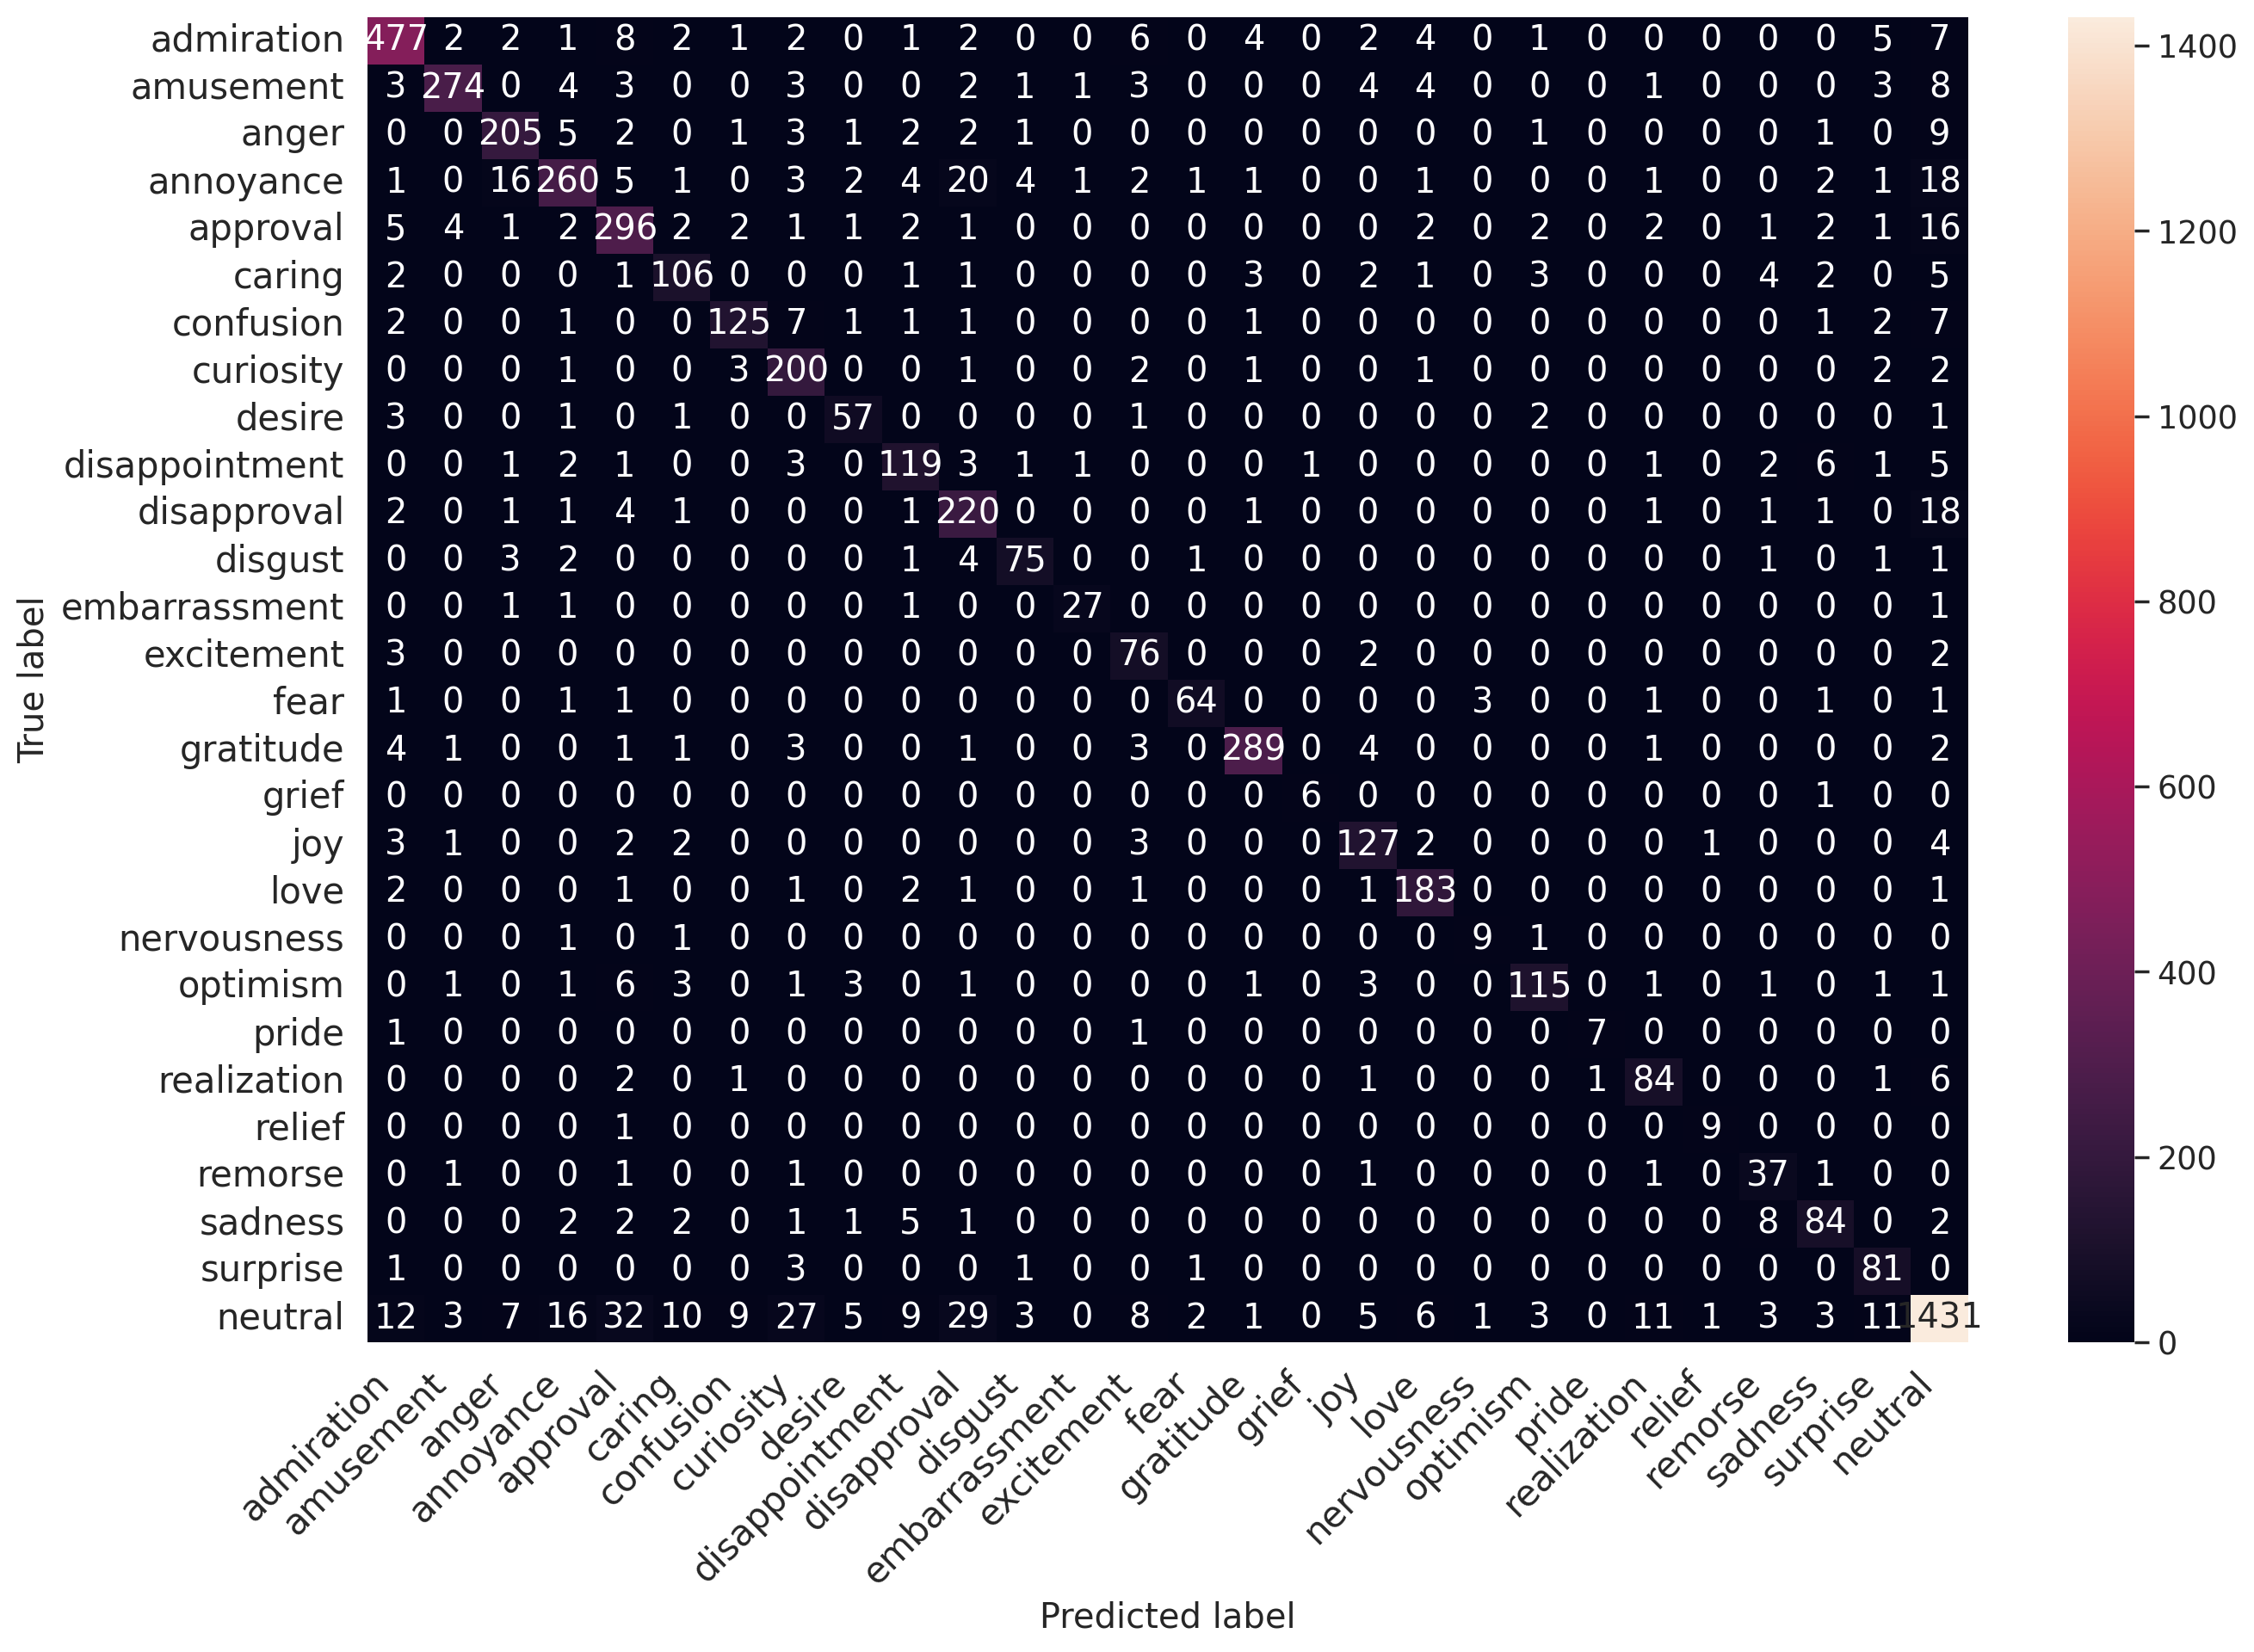

In [ ]:
plt.figure(figsize=(15,10))

class_names = emotion_categories
df_cm = pd.DataFrame(confmat, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5, 73.24999999999999, 'Predicted label')

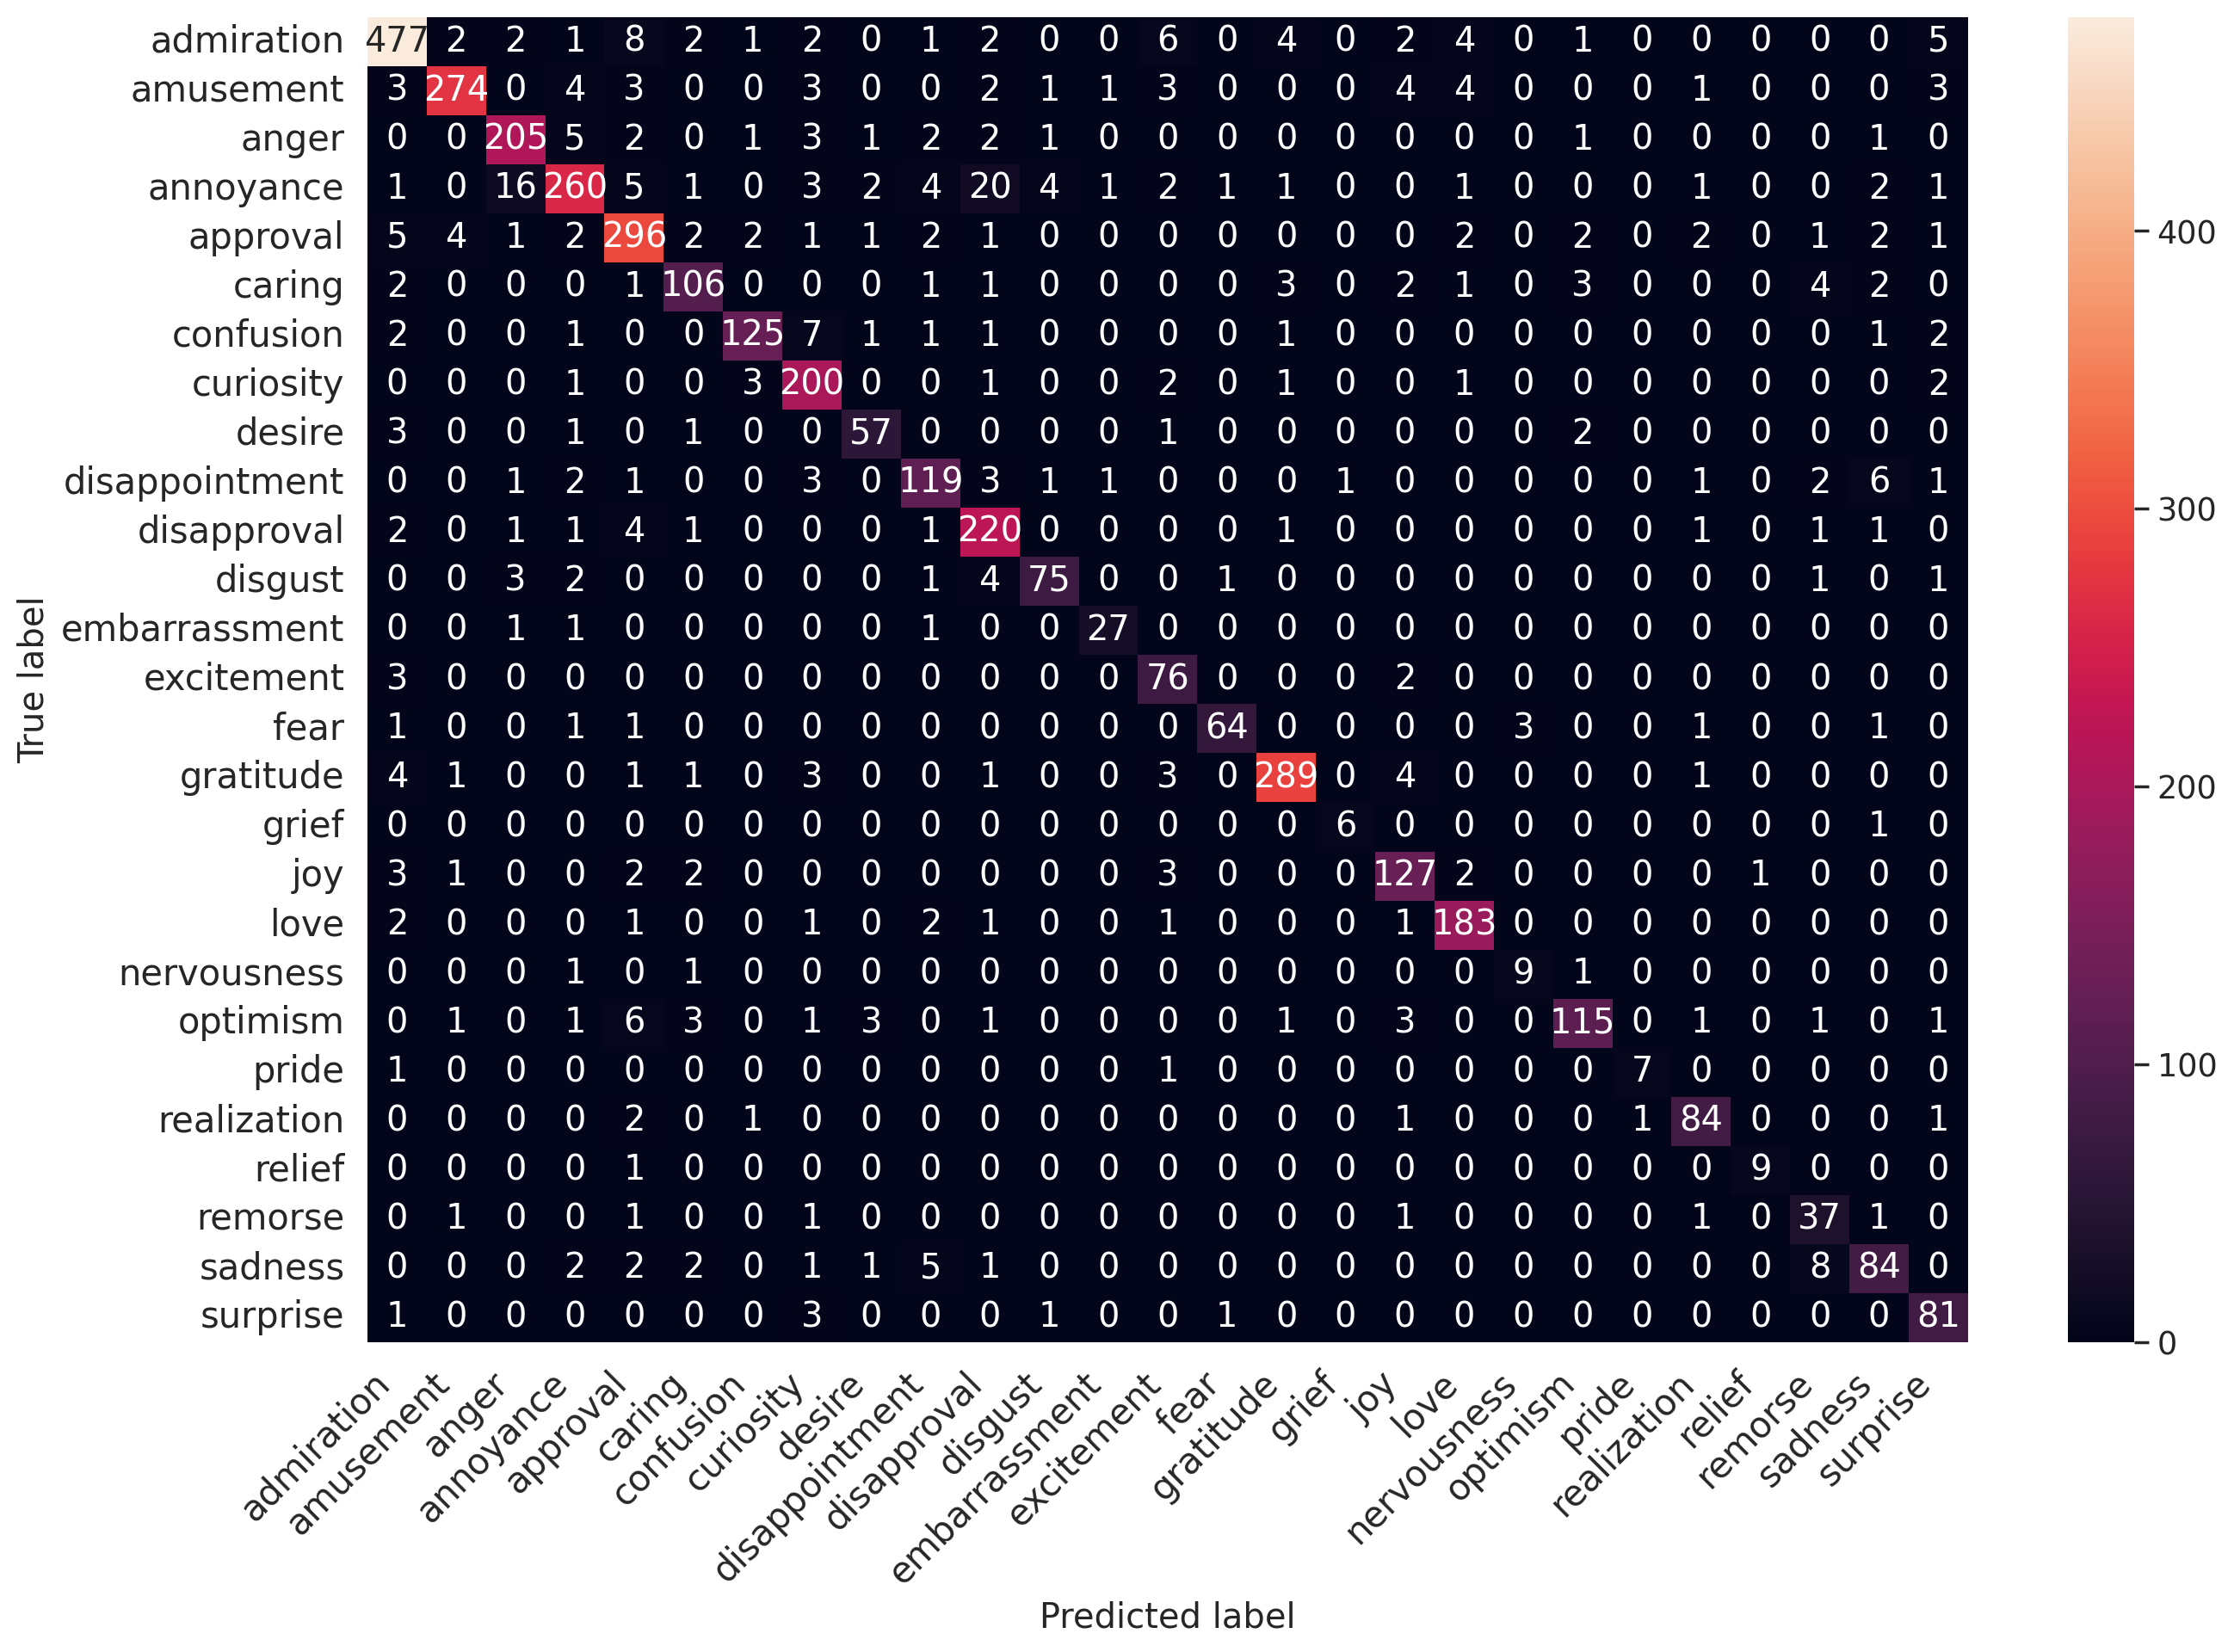

In [ ]:
plt.figure(figsize=(15,10))

class_names = emotion_categories[:-1]
df_cm = pd.DataFrame(confmat[:-1, :-1], index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [ ]:
binary_predictions = torch.nn.functional.one_hot(predictions.argmax(axis=1))
label_encoding_predictions = predictions.argmax(axis=1)
label_encoding_predictions

tensor([ 1, 20, 27,  ...,  0,  0, 10])

In [ ]:
y_pred = label_encoding_predictions.numpy()
y_true = labels.numpy()

In [ ]:
y_pred

array([ 1, 20, 27, ...,  0,  0, 10])

In [ ]:
y_true

array([ 1, 20, 27, ...,  0,  0, 10], dtype=int32)

In [ ]:
#THRESHOLD = 0.5
#upper, lower = 1, 0
#y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=emotion_categories,
  zero_division=0
))

                precision    recall  f1-score   support

    admiration       0.91      0.91      0.91       527
     amusement       0.95      0.87      0.91       314
         anger       0.86      0.88      0.87       233
     annoyance       0.86      0.76      0.80       344
      approval       0.80      0.86      0.83       343
        caring       0.80      0.81      0.81       131
     confusion       0.88      0.84      0.86       149
     curiosity       0.77      0.94      0.85       213
        desire       0.80      0.86      0.83        66
disappointment       0.80      0.81      0.80       147
   disapproval       0.76      0.87      0.81       252
       disgust       0.87      0.84      0.86        89
 embarrassment       0.90      0.87      0.89        31
    excitement       0.72      0.92      0.80        83
          fear       0.93      0.88      0.90        73
     gratitude       0.96      0.93      0.94       310
         grief       0.86      0.86      0.86  

## Further analyzing the dataset

In [ ]:
len(text_df)

58011

In [ ]:
100*text_df.emotion.map(lambda x: emotion_categories[x]).value_counts()/len(text_df)

neutral           28.018824
admiration         9.286170
approval           6.462567
annoyance          5.991967
gratitude          5.224871
amusement          5.124890
anger              4.056127
curiosity          3.949251
disapproval        3.790660
love               3.530365
confusion          2.770164
disappointment     2.342659
caring             2.270259
optimism           2.266811
joy                2.254745
sadness            2.004792
surprise           1.732430
realization        1.579011
excitement         1.465239
disgust            1.342849
desire             1.196325
fear               1.161849
remorse            0.901553
embarrassment      0.544724
nervousness        0.241334
relief             0.201686
pride              0.148248
grief              0.139629
Name: emotion, dtype: float64

<AxesSubplot:>

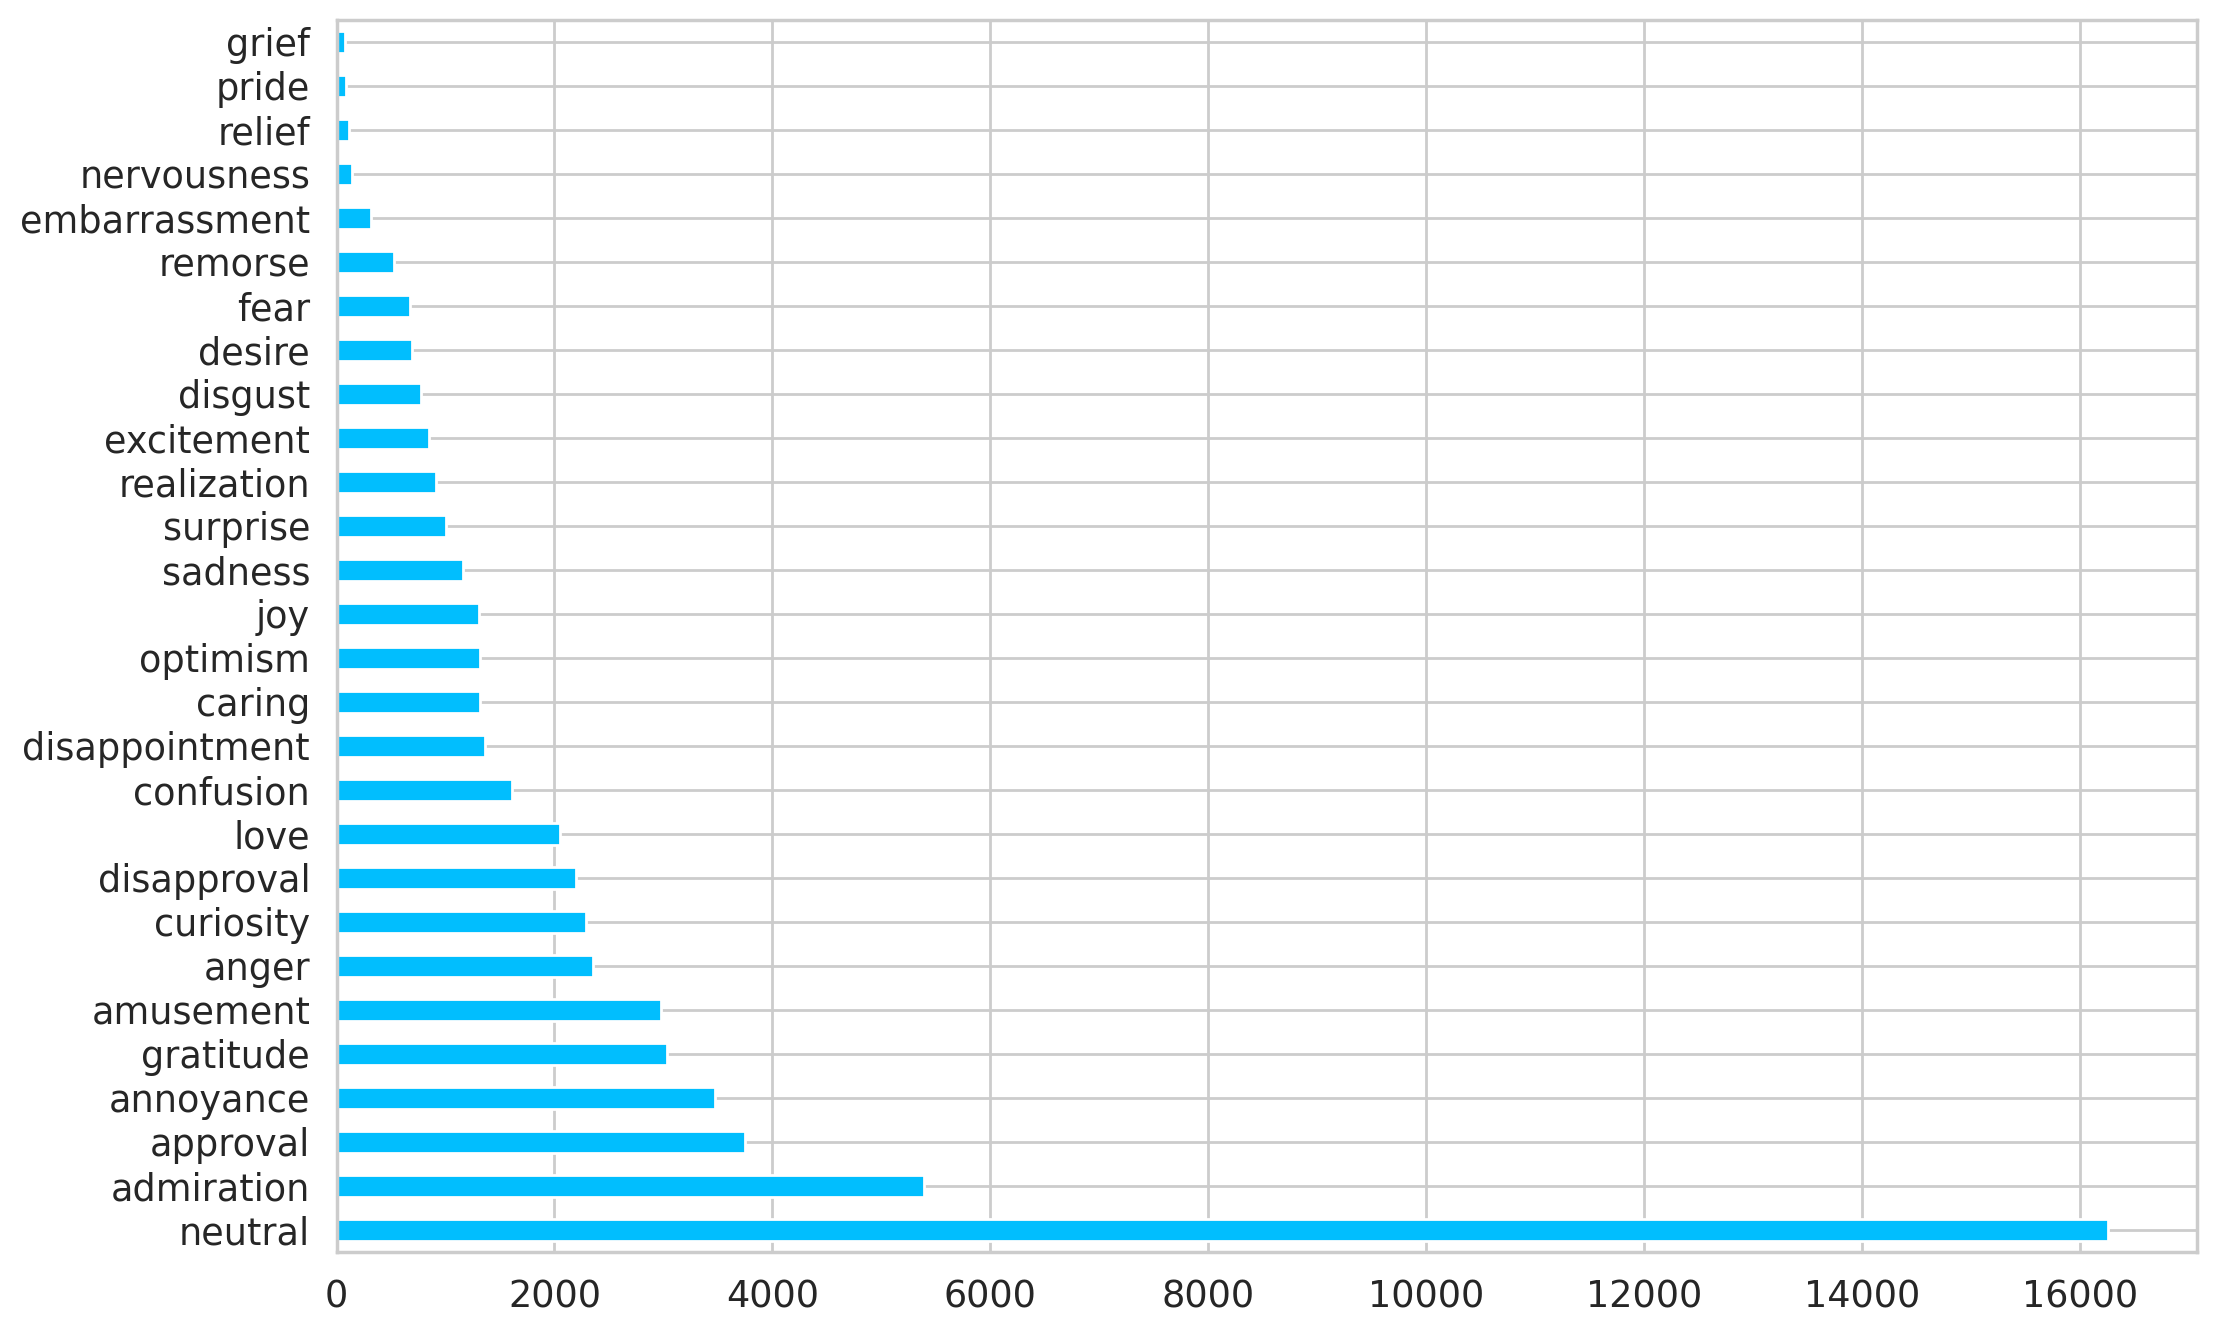

In [ ]:
fig, ax = plt.subplots()
text_df.emotion.map(lambda x: emotion_categories[x]).value_counts().plot(kind="barh", ax=ax)